In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from chesspybara import ChessPybara
from utils import load_data, plot_losses, load_json_dict

torch.manual_seed(39)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
data_dir = '/Home/siv33/vbo084/EloGuessr/data/processed/'

#fnames = ['chess_train_elite_medium.pt', 'chess_val_elite_medium.pt', 'chess_test_elite_medium.pt']
#specnames = ['chess_elite_medium.json']

fnames = ['chess_train_both_full.pt', 'chess_val_both_full.pt', 'chess_test_both_full.pt']
specnames = ['chess_both_full.json']

#fnames = ['chess_train_elite_full.pt', 'chess_val_elite_full.pt', 'chess_test_elite_full.pt']
#specnames = ['chess_elite_full.json']

In [3]:
dset_specs = load_json_dict(os.path.join(data_dir, specnames[0]))
print(dset_specs)
VOCAB_LEN = dset_specs['vocab_len']
PAD_IDX = dset_specs['pad_idx']
MAX_LEN = dset_specs['match_len']

{'pad_idx': 13467, 'vocab_len': 13472, 'match_len': 283}


In [4]:
BATCH_SIZE = 256
train_dloader, val_dloader, test_dloader = load_data(data_dir, fnames, batch_size=BATCH_SIZE)
del test_dloader

In [5]:
config_dict = {'emb_dim': 512,
               'vocab_len': VOCAB_LEN,
               'max_match_len': MAX_LEN,
               'num_heads': 8,
               'num_enc_layers': 8,
               'padding_idx': PAD_IDX,
               'dim_ff': 1024,
               'epochs': 5,
               'lr': 0.0001}

In [6]:
def train_causal(traindloader, valdloader, config_dict, device):

    epochs = config_dict['epochs']
    model = ChessPybara(vocab_len=config_dict['vocab_len'], num_heads=config_dict['num_heads'],
                      num_decoder_layers=config_dict['num_enc_layers'], embdim=config_dict['emb_dim'], dim_ff=config_dict['dim_ff'],
                      padding_idx=config_dict['padding_idx'], max_match_len = config_dict['max_match_len'],
                      device = device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config_dict['lr'])
    loss_fn = nn.CrossEntropyLoss(ignore_index=config_dict['padding_idx'])

    train_losses = []
    val_losses = []

    model = model.to(device)

    # Training and validation loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0

        for batch in traindloader:
            inputs, _ = batch
            targets = inputs[:, 1: ]
            targets = targets.reshape(targets.size(0) * targets.size(1))
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            outputs = outputs[:, :-1, :]
            outputs = outputs.reshape(outputs.size(0) * outputs.size(1), outputs.size(2))

            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(traindloader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in valdloader:
                inputs, _ = batch
                targets = inputs[:, 1: ]
                targets = targets.reshape(targets.size(0) * targets.size(1))
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                outputs = outputs[:, :-1, :]
                outputs = outputs.reshape(outputs.size(0) * outputs.size(1), outputs.size(2))

                loss = loss_fn(outputs, targets)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(valdloader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return model, train_losses, val_losses

/Home/siv33/vbo084/.conda/envs/lmlogic/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/5, Train Loss: 0.8171, Val Loss: 0.0178
Epoch 2/5, Train Loss: 0.0122, Val Loss: 0.0049
Epoch 3/5, Train Loss: 0.0063, Val Loss: 0.0023
Epoch 4/5, Train Loss: 0.0041, Val Loss: 0.0017
Epoch 5/5, Train Loss: 0.0013, Val Loss: 0.0013


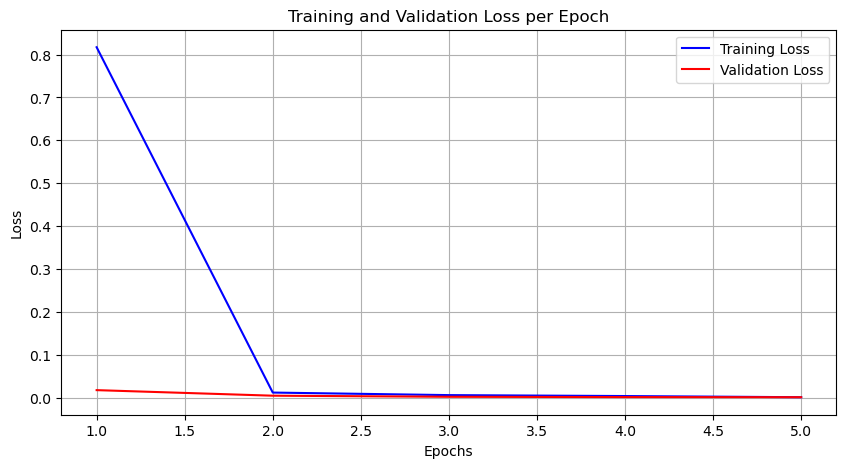

In [7]:
model, tls, vls = train_causal(train_dloader, val_dloader, config_dict, device)
plot_losses(tls, vls)

In [8]:
from utils import save_embedding_layer
emb_data_dir = '/Home/siv33/vbo084/EloGuessr/models/embeddings'
save_embedding_layer(model, os.path.join(emb_data_dir, 'decoder_emb512_both_full.pt'))